# Model Predictive Control of Linear System

Given the state of the system at time zero $x(0)$, we solve the following (open-loop) optimal-control problem 
\begin{align}
V^*(x(0)) :=
\min_{x(\cdot), u(\cdot)} \quad &
\frac{1}{2} \sum_{t=0}^{N-1} x^T(t) Q x(t) + u^T(t) R u(t) + \frac{1}{2} x^T(N) P x(N),
\\
\text{subject to} \quad & x(t+1) = A x(t) + B u(t),
\quad t=0,\ldots, N-1,
\\
& (x(t), u(t)) \in \mathcal D,
\quad t=0,\ldots, N-1,
\\
& x(N) \in \mathcal X_N,
\end{align}
we apply the control $u(0)$ to the system, and we move to the next time step.

In order to ensure the stability of this control approach, we need: i) a terminal controller whose infinite-horizon cost, for a given state $x$, is equal to $\frac{1}{2} x^T P x$, and ii) a set $\mathcal X_N$ such that, for any initial condition inside it, the previous controller will never drive the state $x$ and the input $u$ outside the feasible set $\mathcal D$.

Expressing the generic state $x(t)$ as a function of the initial state $x(0)$ and the control sequence $(u(0), \ldots, u(t-1))$, the problem above assumes the statndard form of a multiparametric Quadratic Program (mpQP)
\begin{align}
V^*(x(0)) :=
\min_{\mathbf u} \quad &
\frac{1}{2}
\begin{bmatrix}
\mathbf u \\ x(0)
\end{bmatrix}^T
H
\begin{bmatrix}
\mathbf u \\ x(0)
\end{bmatrix}
+ f^T
\begin{bmatrix}
\mathbf u \\ x(0)
\end{bmatrix}
+ g,
\\
\text{subject to} \quad &
A
\begin{bmatrix}
\mathbf u \\ x(0)
\end{bmatrix}
\leq b,
\end{align}
where $\mathbf u := (u(0), \ldots, u(N-1))$. This mpQP can be solved explicitly. The resulting $\mathbf u^* (x(0))$ will be a piecewise affine function defined over a polytopic partition of the state space, whereas $V^* (x(0))$ will be piecewise quadratic over the same partition [1].

## Demo

In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem
from pympc.control.controllers import ModelPredictiveController
from pympc.plot import plot_input_sequence, plot_state_trajectory, plot_state_space_trajectory

We consider the linear inverted pendulum from the example $\texttt{maximal_constraint_admissible_set.ipynb}$

In [2]:
# parameters
m = 1.
l = 1.
g = 10.

# continuous time-dynamics
A = np.array([
    [ 0., 1.],
    [g/l, 0.]
    ])
B = np.array([
    [          0.],
    [1./(m*l**2.)]
    ])

# discrete-time system
h = .1
method = 'zero_order_hold'
S = LinearSystem.from_continuous(A, B, h, method)

We set the numeric values for the MPC controller

In [3]:
N = 6
Q = np.array([[1., 0.],[0., 1.]])
R = np.array([[1.]])

As a terminal controller, the obvious chioce is the infinite-horizon LQR, whose cost-to-go can be derived solving the Discrete Algebraic Ricccati Equation (DARE)
\begin{equation}
P = (A+BK)^T P (A+BK) + Q + K^T R K
\end{equation}
where $K = -(B^T P B + R)^{-1} B^T P A$ is the optimal feedback gain $u = K x$

In [4]:
P, K = S.solve_dare(Q, R)

We then consider then the polytopic constraints
\begin{align}
x(t) \in \mathcal X, \quad
u(t) \in \mathcal U \quad
\text{for} \quad
t=0,\ldots, N-1,
\end{align}
and define $\mathcal D := \mathcal X \times \mathcal U$

In [5]:
u_min = np.array([[-6.]])
u_max = np.array([[6.]])
U = Polyhedron.from_bounds(u_min, u_max)
x_min = np.array([[-.5], [-.5]])
x_max = np.array([[.5], [.5]])
X = Polyhedron.from_bounds(x_min, x_max)
D = X.cartesian_product(U)

Regarding the terminal set, the theory of Maximal Constraint-Admissible Invariant Sets (MCAIS) allows us to derive the biggest set for which the desired property holds

In [6]:
X_N = S.mcais(K, D)[0]

Now we have all the ingredients to build the MPC controller

In [7]:
controller = ModelPredictiveController(S, N, Q, R, P, D, X_N)

We can simulate the closed loop system for $N_{\mathrm{sim}}$ steps starting from the initial condition $x_0$

In [8]:
Nsim = 50
x0 = np.array([[.4],[.4]])
u = []
x = [x0]
for t in range(Nsim):
    u.append(controller.feedback(x[t]))
    x.append(S.A.dot(x[t]) + S.B.dot(u[t]))

And plot the input and the state trajectories

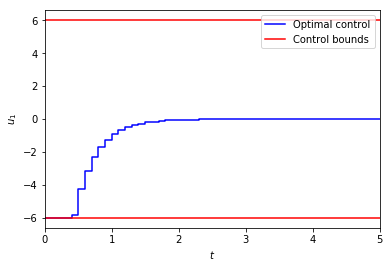

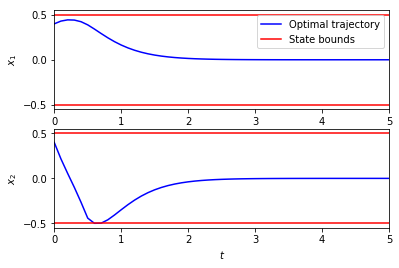

In [9]:
plot_input_sequence(u, h, (u_min, u_max))
plt.show()
plot_state_trajectory(x, h, (x_min, x_max))
plt.show()

We can get the explict solution of the optimal control problem as a function of the intial state $x_0$, solving the resulting mpQP

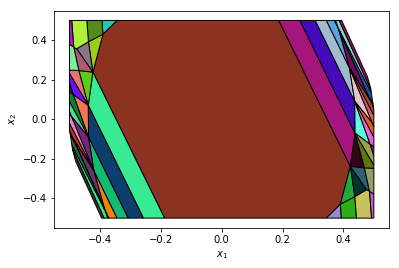

In [10]:
controller.store_explicit_solution(verbose=True)
controller.plot_state_space_partition()
plt.show()

We then check that the explicit solution and solution of the optimization give the same answer.

In [11]:
u_explicit, V_explicit = controller.feedforward_explicit(x0)
u_implicit, V_implicit = controller.feedforward(x0)
print('Explicit solution:\nu*(x0) = ' + str([u.flatten().tolist() for u in u_explicit]) +
      ',\nV*(x0) = ' + str(V_explicit) + '\n')
print('Implicit solution:\nu*(x0) = ' + str([u.flatten().tolist() for u in u_implicit]) +
      ',\nV*(x0) = ' + str(V_implicit))

Explicit solution:
u*(x0) = [[-5.9999999999999964], [-6.000000000000012], [-6.000000000000004], [-6.000000000000008], [-5.8391515796059075], [-4.233347323493479]],
V*(x0) = 110.36601181133847

Implicit solution:
u*(x0) = [[-5.999999999999915], [-6.0], [-6.000000000000043], [-6.000000000000028], [-5.839151579605975], [-4.233347323493547]],
V*(x0) = 110.36601181133847


The standard proof of stability for an MPC controller relies on the fact that the optimal value function $V(x)$ is a Lyapunov function for the closed-loop system, we can plot the level sets of $V(x)$ and the closed loop trajectory to verify this

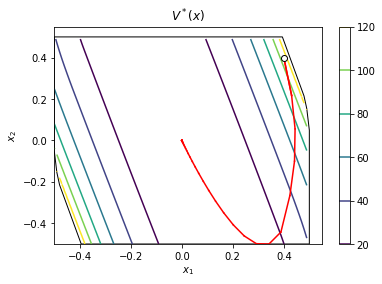

In [12]:
controller.plot_optimal_value_function(facecolor='white', edgecolor='black')
plot_state_space_trajectory(x, color='red')
plt.show()

## References

[1] Bemporad, A., Morari, M., Dua, V. and Pistikopoulos, E.N., 2002. The explicit linear quadratic regulator for constrained systems. Automatica, 38(1), pp.3-20.